这一部分从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

%matplotlib inline 是一个 Jupyter Notebook 的魔法命令。当你在 Jupyter Notebook 中使用它时，它可以使 Matplotlib 生成的图形直接嵌入到你的 Notebook 中，而不是在新窗口中打开。

简单来说，当你在 Jupyter Notebook 中绘制图形时，使用 %matplotlib inline 可以确保图形直接显示在代码单元格下方，而不是需要手动关闭的独立窗口。

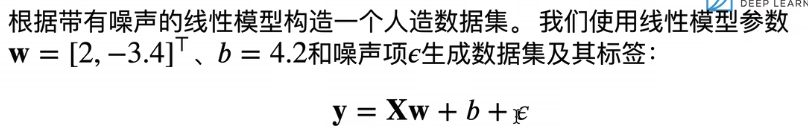![image.png](attachment:792a9d6a-c5c7-46bf-97e9-00f9c6b5a976.png)

torch.normal是PyTorch中的一个函数，用于生成服从正态分布的随机数。

具体来说，torch.normal函数接受三个参数：mean、std和size。其中，mean是正态分布的均值，std是正态分布的标准差，size是输出随机数的形状。

例如，如果你想生成一个形状为(3, 2)的张量，其元素服从均值为0、标准差为1的正态分布，你可以使用以下代码：

In [2]:
mean = torch.zeros(3, 2)
std = torch.ones(3, 2)
normal_samples = torch.normal(mean, std)
normal_samples

tensor([[ 0.9122,  0.2444],
        [-0.2465,  0.1721],
        [ 1.1066, -1.2310]])

In [3]:
def synthtic_data(w, b, num_examples):
    # 生成 y = Xw + b + 噪音
    X = torch.normal(0, 1, (num_examples, len(w)))
    print("X.shape:",X.shape)
    y = torch.matmul(X, w) + b
    print("y.shape:",y.shape)
    y += torch.normal(0, 0.01, y.shape)
    print("y.shape:",y.shape)
    print("y.reshape((-1,1)).shape:",y.reshape((-1,1)).shape)

    return X, y.reshape((-1,1))

* `w`: 这是一个包含两个元素的张量，代表线性模型的权重。  
* `b`: 这是一个标量，代表线性模型的偏置。  
* `num_examples`: 这是一个整数，表示要生成的样本数量。

X = torch.normal(0, 1, (num_examples, len(w)))

这里使用正态分布生成了一个 num_examples 行和 len(w) 列的矩阵。每个元素都是从均值为0、标准差为1的正态分布中随机抽取的。

y = torch.matmul(X, w) + b

这行代码实际上计算了每个样本的线性预测值。它首先计算 X 和 w 的矩阵乘法，然后加上偏置 b。

y += torch.normal(0, 0.01, y.shape)

为了使数据更接近真实世界中的情况，我们在预测值上添加了一些噪声。噪声是从均值为0、标准差为0.01的正态分布中随机抽取的，其形状与 y 的形状相同。

return X, y.reshape((-1,1))

最后，函数返回特征矩阵 X 和目标向量 y。由于 y 的形状是 [num_examples]，为了使其与 X 的形状兼容，我们使用 reshape((-1,1)) 将它转换为一个列向量。

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthtic_data(true_w, true_b, 1000)

X.shape: torch.Size([1000, 2])
y.shape: torch.Size([1000])
y.shape: torch.Size([1000])
y.reshape((-1,1)).shape: torch.Size([1000, 1])


In [5]:
import torch

def reshape_data(data):
    # 将数据转换为张量
    tensor_data = torch.tensor(data)

    # 将数据重塑为列矩阵
    reshaped_data = tensor_data.reshape((-1, 1))

    return reshaped_data

# 示例数据
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# 调用函数并打印结果
reshaped_data = reshape_data(data)
print(reshaped_data)

tensor([[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10]])


features 中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）

In [6]:
print('features:',features[0],'\nlabels:',labels[0])

features: tensor([0.8992, 0.3101]) 
labels: tensor([4.9283])


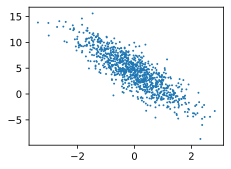

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
               labels.detach().numpy(),1)

这是一个Python代码片段，通常用于处理PyTorch张量（tensor）。让我们分解这个代码来理解每个部分的作用：

features: 这是一个PyTorch张量（tensor），可能是一个二维张量，其中每一行代表一个样本，每一列代表一个特征。
[:,1]: 这是一个切片操作。: 表示我们想要获取所有的行，而 1 表示我们只想获取第二列（Python中的索引是从0开始的）。
detach(): 这是PyTorch中的一个方法，用于从计算图中分离一个张量，从而防止进一步的计算或跟踪。当你对一个张量使用 detach() 时，它返回一个新的张量，这个张量与原始张量有相同的数据，但与计算图没有连接。
numpy(): 这是将PyTorch张量转换为NumPy数组的方法。NumPy是一个用于处理数组的Python库，它提供了大量的数学函数来操作这些数组。
所以，features[:,1].detach().numpy() 的整体意思是：从 features 张量中获取第二列，从计算图中分离这个列，然后将其转换为NumPy数组。

定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        # print("batch_indices:",batch_indices)
        yield features[batch_indices],labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.2110, -1.1049],
        [ 0.3583, -0.2650],
        [ 0.0926, -1.1646],
        [ 0.1095,  0.7538],
        [ 1.1295, -0.9652],
        [-0.2344, -1.1999],
        [ 1.4793, -0.7864],
        [ 1.5739,  0.3852],
        [ 0.2924, -0.6098],
        [ 1.5300, -0.2645]]) 
 tensor([[5.5381],
        [5.8180],
        [8.3317],
        [1.8557],
        [9.7373],
        [7.8074],
        [9.8285],
        [6.0324],
        [6.8579],
        [8.1520]])


indices[i:min(i + batch_size, num_examples)]:

这是一个Python的切片操作。它从indices列表中提取一个子列表。开始索引是i，结束索引是min(i + batch_size, num_examples)。

i + batch_size: 这是结束索引的理论值。
min(i + batch_size, num_examples): 使用min函数来确定结束索引的实际值。如果i + batch_size大于num_examples，那么结束索引将是num_examples。
torch.tensor(...): 这将上述提取的子列表转换为一个PyTorch张量（tensor）。

总的来说，这一行代码从indices列表中提取一个子列表，并将其转换为一个PyTorch张量。这个子列表的长度是batch_size，除非总长度小于batch_size，在这种情况下，子列表将包含剩余的元素。

yield features[batch_indices],labels[batch_indices]

这一行代码在Python中使用了`yield`关键字，它是用于生成器函数中的。

`yield`关键字的作用是暂停函数的执行，并返回一个值。当函数再次被调用时，它将从上次`yield`的位置继续执行。

在这个特定的代码中：


```python
yield features[batch_indices], labels[batch_indices]
```
1. `features[batch_indices]`：从`features`列表或数组中提取由`batch_indices`指定的元素。
2. `labels[batch_indices]`：从`labels`列表或数组中提取由`batch_indices`指定的元素。
3. 这两个值（`features[batch_indices]`和`labels[batch_indices]`）一起被返回给调用者，并作为生成器的返回值。

使用`yield`的目的是为了使函数成为一个生成器，这样它可以在多次调用之间保留状态。这在处理大量数据或需要分批处理数据时非常有用，因为它可以节省内存并提高效率。

定义初始化模型参数

In [9]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
这行代码使用了PyTorch，一个流行的深度学习框架。下面我会为你逐个解释这行代码的每个部分：


```python
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
```
1. **`torch.normal`**：这是PyTorch中的一个函数，用于从正态分布中生成随机数。
2. **`0`**：这是正态分布的均值。
3. **`0.01`**：这是正态分布的标准差。
4. **`size=(2,1)`**：这指定了生成的张量的形状。在这里，我们想要一个2行1列的张量，即一个2x1的矩阵。
5. **`requires_grad=True`**：这表示该张量需要计算其梯度。当你在PyTorch中定义一个计算图时（例如使用`torch.autograd.grad`或其他相关函数），这个标志会告诉PyTorch跟踪这个张量的梯度，以便稍后进行反向传播和优化。

所以，这行代码的总体意思是：从均值为0、标准差为0.01的正态分布中生成一个2x1的张量，并设置该张量需要计算其梯度。

定义模型

In [10]:
def linreg(X, w, b):
    # 线性回归模型
    return torch.matmul(X, w) + b

定义损失函数

In [11]:
def squared_loss(y_hat, y):
    # 均方损失
    # print("start squared_loss")
    # print("y_hat:",y_hat)
    # print("y_hat.shape:",y_hat.shape)
    # print("y:",y)
    # print("y.shape:",y.shape)
    # print("y.reshape(y_hat.shape)):",y.reshape(y_hat.shape))
    # print("y.reshape(y_hat.shape)).shape:",y.reshape(y_hat.shape).shape)
    # print("end squared_loss")
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [12]:
def sgd(params, lr, batch_size):
    # 小批量随机梯度下降
    # print("start sgd")
    # print("params:",params)
    with torch.no_grad():
        for param in params:
            # print("param:",param)
            # print("param.grad:",param.grad)
            param -= lr * param.grad / batch_size
            param.grad.zero_()
    # print("end sgd")

训练过程

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)

        l.sum().backward()
        sgd([w,b], lr, batch_size)
        # input()
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041953
epoch 2, loss 0.000187
epoch 3, loss 0.000055




```

batch_indices: tensor([558, 333,  11, 456, 802, 727, 775, 715, 782, 638])
start squared_loss
y_hat: tensor([[-0.0045],
        [ 0.0102],
        [ 0.0026],
        [ 0.0021],
        [-0.0004],
        [ 0.0046],
        [-0.0053],
        [ 0.0011],
        [-0.0039],
        [-0.0028]], grad_fn=<AddBackward0>)
y_hat.shape: torch.Size([10, 1])
y: tensor([[9.0311],
        [2.3559],
        [3.9183],
        [3.6681],
        [1.8604],
        [3.2758],
        [8.9792],
        [4.5990],
        [5.7077],
        [8.3949]])
y.shape: torch.Size([10, 1])
y.reshape(y_hat.shape)): tensor([[9.0311],
        [2.3559],
        [3.9183],
        [3.6681],
        [1.8604],
        [3.2758],
        [8.9792],
        [4.5990],
        [5.7077],
        [8.3949]])
y.reshape(y_hat.shape)).shape: torch.Size([10, 1])
end squared_loss
start sgd
params: [tensor([[0.0002],
        [0.0055]], requires_grad=True), tensor([0.], requires_grad=True)]
param: tensor([[0.0002],
        [0.0055]], requires_grad=True)
param.grad: tensor([[-34.4243],
        [ 14.3774]])
param: tensor([0.], requires_grad=True)
param.grad: tensor([-51.7869])
end sgd
```



比较真实参数和通过训练学到的参数来评估训练的成功程度

In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b} - b')

w的估计误差: tensor([ 0.0004, -0.0008], grad_fn=<SubBackward0>)
b的估计误差: 4.2 - b
